In [2]:
import numpy as np
import edf
from time import time
import sys
import matplotlib.pyplot as plt

In [3]:
traindata = './mnist_data/train.npz'
valdata = './mnist_data/test.npz'

data = np.load(traindata)
t_imgs = np.float32(data['imgs'])/255.
t_labels = np.float32(data['labels'])

data = np.load(valdata)
v_imgs = np.float32(data['imgs'])/255.
v_labels = np.float32(data['labels'])

Random accuracy = 0.0958
Epoch 0: train loss = 0.2460 [57.078 secs]
test accuracy=0.9268
Epoch 1: train loss = 0.1687 [63.828 secs]
test accuracy=0.9507
Epoch 2: train loss = 0.1340 [60.730 secs]
test accuracy=0.9576
Epoch 3: train loss = 0.1057 [61.494 secs]
test accuracy=0.9636
Epoch 4: train loss = 0.0886 [62.024 secs]
test accuracy=0.9681
Epoch 5: train loss = 0.0756 [74.404 secs]
test accuracy=0.9702
Epoch 6: train loss = 0.0638 [78.362 secs]
test accuracy=0.9730
Epoch 7: train loss = 0.0654 [75.909 secs]
test accuracy=0.9713
Epoch 8: train loss = 0.0504 [75.464 secs]
test accuracy=0.9754
Epoch 9: train loss = 0.0444 [87.701 secs]
test accuracy=0.9758


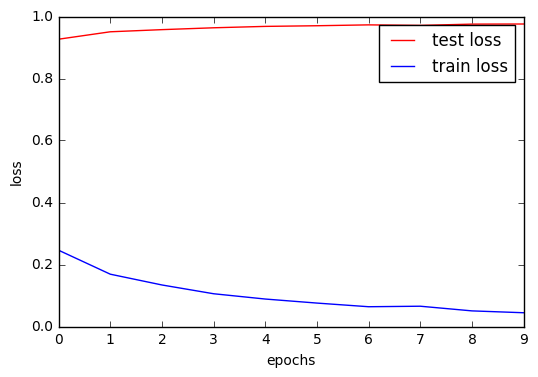

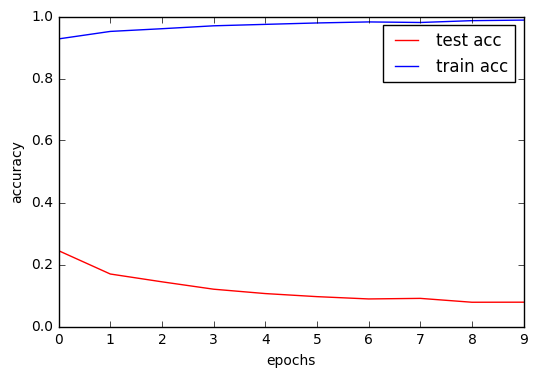

In [4]:
####################################we use sigmoid to demonstrate the edf works###################################
# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28,128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128,10)))
B2 = edf.Param(np.zeros((10)))

########### Model #############
A1 = edf.Add(edf.VDot(inp,W1),B1)
hidden = edf.Sigmoid(A1)
A2 = edf.Add(edf.VDot(hidden,W2),B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred,lab))
loss = edf.Mul(log,edf.Value(-1))
acc = edf.Accuracy(pred,lab)


# evaluation function
def eval(v_imgs, v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy, objective

accuracy,objective = eval(v_imgs, v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01
epoch = 10

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc, avg_loss = eval(t_imgs, t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, avg_loss,time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc, avg_loss = eval(v_imgs, v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_acc)
    test_acc.append(avg_loss)
    stime = time()
    ep += 1

# plot
plt.figure(1)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)), test_loss, color='red')
plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
plt.legend(['test loss', 'train loss'], loc='upper right')
plt.show

plt.figure(2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, color='red')
plt.plot(np.arange(len(train_acc)), train_acc, color='blue')
plt.legend(['test acc', 'train acc'], loc='upper right')
plt.show()

Random accuracy = 0.0875
Epoch 0: train loss = 0.1406 [203.365 secs]
test accuracy=0.9550
Epoch 1: train loss = 0.0833 [187.275 secs]
test accuracy=0.9697
Epoch 2: train loss = 0.0613 [180.917 secs]
test accuracy=0.9715
Epoch 3: train loss = 0.0414 [164.453 secs]
test accuracy=0.9742
Epoch 4: train loss = 0.0371 [165.395 secs]
test accuracy=0.9752
Epoch 5: train loss = 0.0276 [180.237 secs]
test accuracy=0.9754
Epoch 6: train loss = 0.0213 [180.862 secs]
test accuracy=0.9773
Epoch 7: train loss = 0.0179 [183.739 secs]
test accuracy=0.9773
Epoch 8: train loss = 0.0118 [182.876 secs]
test accuracy=0.9782
Epoch 9: train loss = 0.0082 [176.872 secs]
test accuracy=0.9791


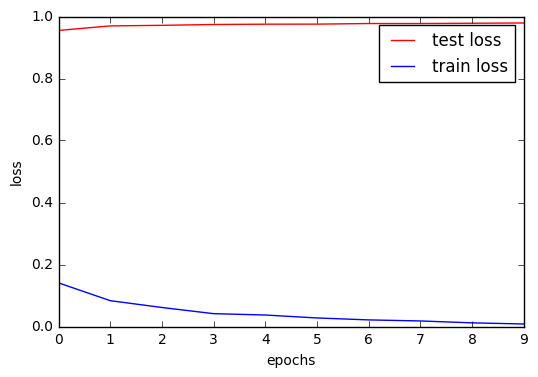

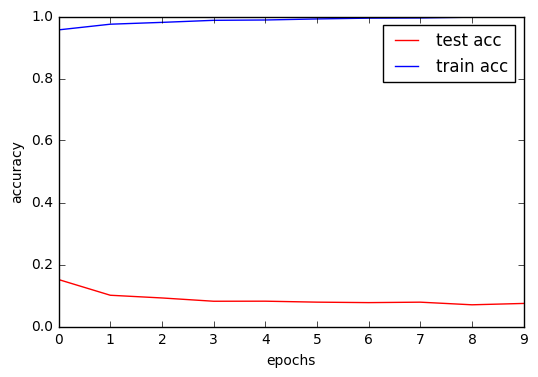

In [5]:
# please complete the forward and backward function in Tanh class and test it.
class Tanh:
    
    def __init__(self,x):
        edf.components.append(self)
        self.x = x
        self.grad = None if x.grad is None else edf.DT(0)

    def forward(self):
        exp2 = np.exp(2.*self.x.value)
        self.value = np.divide(exp2-1,exp2+1)
        
    def backward(self):
        if self.x.grad is not None:
            self.x.grad = self.x.grad + self.grad * (1- np.square(self.value))

# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28,128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128,10)))
B2 = edf.Param(np.zeros((10)))

########### Model #############
# Here we change sigmoid to Tanh
A1 = edf.Add(edf.VDot(inp,W1),B1)
hidden = Tanh(A1)
A2 = edf.Add(edf.VDot(hidden,W2),B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred,lab))
loss = edf.Mul(log,edf.Value(-1))
acc = edf.Accuracy(pred,lab)


# evaluation function
def eval(v_imgs, v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy, objective

accuracy,objective = eval(v_imgs, v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01
epoch = 10

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc, avg_loss = eval(t_imgs, t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, avg_loss,time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc, avg_loss = eval(v_imgs, v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_acc)
    test_acc.append(avg_loss)
    stime = time()
    ep += 1

# after training, you should be able to get around 97% test accuracy and training loss under 0.1 on mnist data.
# plot
plt.figure(1)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)), test_loss, color='red')
plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
plt.legend(['test loss', 'train loss'], loc='upper right')
plt.show

plt.figure(2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, color='red')
plt.plot(np.arange(len(train_acc)), train_acc, color='blue')
plt.legend(['test acc', 'train acc'], loc='upper right')
plt.show()

In [ ]:
# please complete the forward and backward function in Relu class and test it.
class Relu:

    def __init__(self,x):
        edf.components.append(self)
        self.x = x
        self.grad = None if x.grad is None else edf.DT(0)

    def forward(self):
        self.value = np.maximum(self.x.value, 0)
        
    def backward(self):
        if self.x.grad is not None:
            derivative = np.greater(self.x.value, 0)
            self.x.grad = self.x.grad + np.multiply(self.grad, derivative) 
# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28,128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128,10)))
B2 = edf.Param(np.zeros((10)))

########### Model #############
# Here we change sigmoid to relu
A1 = edf.Add(edf.VDot(inp,W1),B1)
hidden = Relu(A1)
A2 = edf.Add(edf.VDot(hidden,W2),B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred,lab))
loss = edf.Mul(log,edf.Value(-1))
acc = edf.Accuracy(pred,lab)

# evaluation function
def eval(v_imgs, v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy, objective

accuracy,objective = eval(v_imgs, v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01
epoch = 10

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc, avg_loss = eval(t_imgs, t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, avg_loss,time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc, avg_loss = eval(v_imgs, v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_acc)
    test_acc.append(avg_loss)
    stime = time()
    ep += 1

# after training, you should be able to get around 97% test accuracy and training loss under 0.1 on mnist data.
# plot
plt.figure(1)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)), test_loss, color='red')
plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
plt.legend(['test loss', 'train loss'], loc='upper right')
plt.show

plt.figure(2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, color='red')
plt.plot(np.arange(len(train_acc)), train_acc, color='blue')
plt.legend(['test acc', 'train acc'], loc='upper right')
plt.show()

Random accuracy = 0.1323
